# Билет 18

## Номер 3

In [95]:
import matplotlib.pyplot as plt
import torch

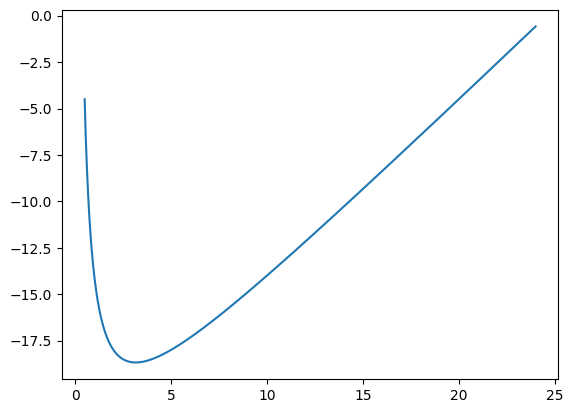

In [96]:
def f(x: torch.Tensor) -> torch.Tensor:
    return (x * x - 25 * x + 10) / x


X = torch.arange(0.5, 24 + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

In [97]:
# 20 - можно выбрать любое другое число из интервала
x = torch.tensor(20, dtype=torch.float, requires_grad=True)

history = []
while True:
    history.append(x.detach().clone())
    y = f(x)
    y.backward()
    grad = x.grad.clone()
    x.grad.zero_()
    with torch.no_grad():
        x -= 0.01 * grad  # простой градиентный спуск c lr=0.01
        if torch.abs(x - history[-1]) <= 0.000001:  # точность поиска
            history.append(x.detach().clone())
            break

[tensor(20.), tensor(19.5128), tensor(19.0263), tensor(18.5404), tensor(18.0554), tensor(17.5711), tensor(17.0878), tensor(16.6054), tensor(16.1240), tensor(15.6438), tensor(15.1649), tensor(14.6873), tensor(14.2113), tensor(13.7369), tensor(13.2643), tensor(12.7937), tensor(12.3254), tensor(11.8596), tensor(11.3966), tensor(10.9367), tensor(10.4802), tensor(10.0278), tensor(9.5798), tensor(9.1369), tensor(8.6997), tensor(8.2691), tensor(7.8461), tensor(7.4318), tensor(7.0275), tensor(6.6346), tensor(6.2550), tensor(5.8906), tensor(5.5436), tensor(5.2164), tensor(4.9115), tensor(4.6312), tensor(4.3778), tensor(4.1529), tensor(3.9572), tensor(3.7906), tensor(3.6520), tensor(3.5390), tensor(3.4489), tensor(3.3782), tensor(3.3237), tensor(3.2822), tensor(3.2509), tensor(3.2276), tensor(3.2102), tensor(3.1974), tensor(3.1880), tensor(3.1810), tensor(3.1760), tensor(3.1723), tensor(3.1696), tensor(3.1676), tensor(3.1661), tensor(3.1651), tensor(3.1643), tensor(3.1638), tensor(3.1634), tenso

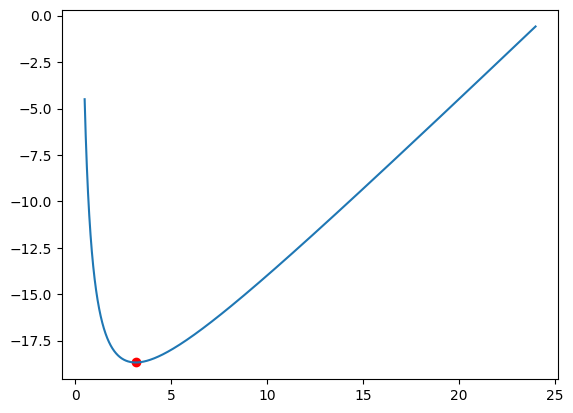

In [98]:
print(history[::50])
x = history[-1]
x, y = x.item(), f(x).item()
print(f"\n\n{x}, {y}")
plt.plot(X.detach(), Y.detach())
plt.scatter(x, y, color="r");

## Номер 2

In [99]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [100]:
%matplotlib inline

In [101]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


Очень большие картинки в датасете, уменьшу до 100x100:

332


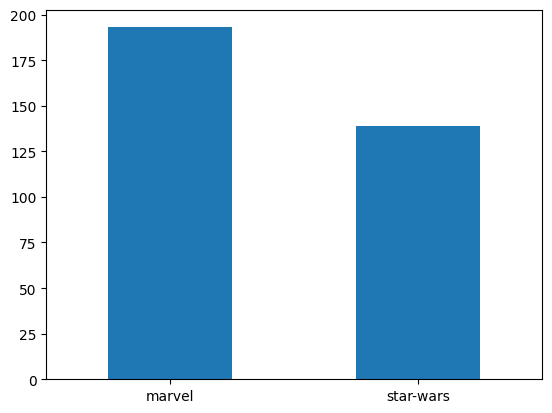

In [102]:
transform = transforms.Compose([
    transforms.Resize(size=(100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
dataset = ImageFolder("../data/images/chars", transform=transform)

vc = pd.value_counts(dataset.targets)
vc.index = [dataset.classes[i] for i in vc.index]
print(len(dataset))
vc.plot.bar(rot=0);

Почти сбалансированная выборка

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

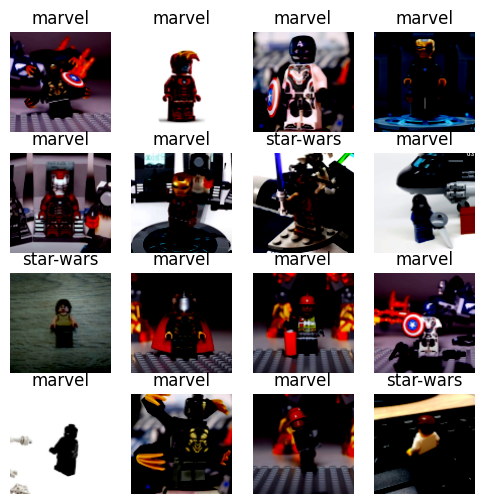

In [103]:
_, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in zip(torch.randperm(len(dataset)), axes.flatten()):
    img, target = dataset[i]
    ax.axis("off")
    ax.set_title(dataset.classes[target])
    ax.imshow(img.permute(1, 2, 0))

Цвета поломались из-за нормализации, но суть картинок ясна - нужно решить задачу классификации - определить является ли фигурка LEGO персонажем из MARVEL или STAR-WARS

Разделение выборки на обучающую 80% и тестовую 20%:

In [104]:
test_size = round(0.2 * len(dataset))
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
len(train_dataset), len(test_dataset)

(266, 66)

Cверточная нейронная сеть: 3 сверточных слоя, 4 линейных, дропауты для борьбы с переобучением

In [105]:
class CNNClassifier(nn.Module):

    def __init__(self, num_channels: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((8, 8))
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [106]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


net = CNNClassifier(
    num_channels=train_dataset[0][0].size(0),
    num_classes=len(dataset.classes),
).to(DEVICE)
weights = get_weights(torch.tensor([target for _, target in train_dataset], device=DEVICE))
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(net.parameters(), lr=0.00015)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

net

CNNClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(8, 8))
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=

In [107]:
@torch.no_grad()
def test_loop(dataloader, model, loss_fn):
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y.unsqueeze(1))
        y_pred.append(pred)

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)

In [108]:
train_losses, train_accuracy_list = [], []
test_losses, test_accuracy_list = [], []
for epoch in range(19):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)

    # ============ TRAIN ============
    net.train()
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    avg_loss, avg_accuracy = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)
        avg_loss += loss
        avg_accuracy += accuracy
    train_loss, train_accuracy = (avg_loss / num_batches).item(), avg_accuracy / num_batches
    print(f"Train: loss={train_loss:.6f}, accuracy={train_accuracy:.4f}")
    train_losses.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    # ============ TEST ============
    test_loss, test_accuracy = test_loop(test_dataloader, net, loss_fn)
    print(f"Test: loss={test_loss:.6f}, accuracy={test_accuracy:.4f}\n")
    test_losses.append(test_loss)
    test_accuracy_list.append(test_accuracy)

Epoch 1
--------------------------------
Train: loss=0.691530, accuracy=0.5757
Test: loss=0.689450, accuracy=0.6818

Epoch 2
--------------------------------
Train: loss=0.685386, accuracy=0.5551
Test: loss=0.682550, accuracy=0.5606

Epoch 3
--------------------------------
Train: loss=0.682543, accuracy=0.5831
Test: loss=0.667948, accuracy=0.6364

Epoch 4
--------------------------------
Train: loss=0.621238, accuracy=0.6478
Test: loss=0.624723, accuracy=0.7121

Epoch 5
--------------------------------
Train: loss=0.636519, accuracy=0.6257
Test: loss=0.638230, accuracy=0.6364

Epoch 6
--------------------------------
Train: loss=0.587648, accuracy=0.6919
Test: loss=0.577373, accuracy=0.6970

Epoch 7
--------------------------------
Train: loss=0.573219, accuracy=0.7235
Test: loss=0.588094, accuracy=0.6515

Epoch 8
--------------------------------
Train: loss=0.467516, accuracy=0.7537
Test: loss=0.527050, accuracy=0.7727

Epoch 9
--------------------------------
Train: loss=0.534924, a

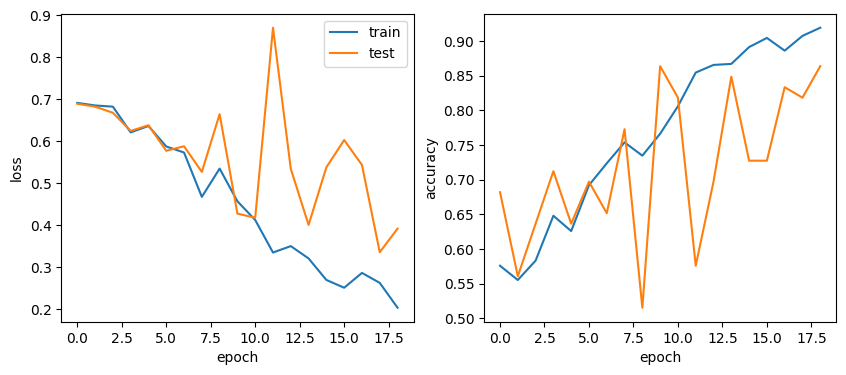

In [109]:
_, axes = plt.subplots(1, 2, figsize=(10, 4))
epochs = torch.arange(len(train_losses))

axes[0].plot(epochs, train_losses)
axes[0].plot(epochs, test_losses)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_accuracy_list)
axes[1].plot(epochs, test_accuracy_list)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy");

По графику видна большая дисперсия в батчах данных и начало переобучения модели

              precision    recall  f1-score   support

      marvel       0.90      0.88      0.89        43
   star-wars       0.79      0.83      0.81        23

    accuracy                           0.86        66
   macro avg       0.85      0.85      0.85        66
weighted avg       0.87      0.86      0.86        66



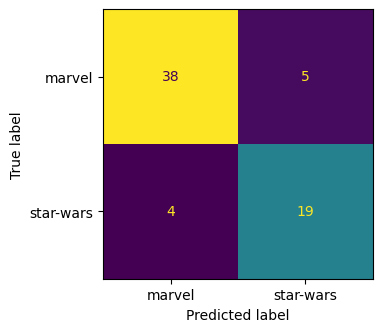

In [110]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=dataset.classes,
    colorbar=False,
    xticks_rotation=0,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

print(metrics.classification_report(y_true, y_pred, target_names=dataset.classes, zero_division=True))

Модель хорошего качества несмотря на небольшое количество примеров.